### Import libraries and functions

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from utils_functions import preprocess, split_data, mean_std_acc
import model_manager as mm

In [3]:
%matplotlib inline

In [4]:
tf.__version__

'2.0.0'

### Load training set from Pickle files
* The raw data is logged into JSON files from the device. 
* The JSON files are parsed and the data are saved in Pickle files.
* The data includes the accelerometer measures (x, y, z) and the ground-truth labels.

In [141]:
# 10 digits to be classified
num_classes = 10
input_size = 130

In [142]:
with open('x_raw.pickle', 'rb') as handle:
    x_raw = pickle.load(handle)
with open('label.pickle', 'rb') as handle:
    label = pickle.load(handle)

In [143]:
print("There are {0} gestures and {1} corresponding labels in the training set.".format(len(x_raw), len(label)))

There are 457 gestures and 457 corresponding labels in the training set.


### Load test sets from Pickle files

In [144]:
with open('test_x_raw.pickle', 'rb') as handle:
    test_x_raw = pickle.load(handle)
with open('test_label.pickle', 'rb') as handle:
    test_label = pickle.load(handle)
tmp = np.asarray(preprocess(input_size, test_x_raw))
test_X = np.asarray(tmp, dtype=np.float32).reshape(tmp.shape[0], -1)
test_y = np.eye(num_classes)[np.array(test_label)]
print("The shape of test 1: X {0}, y {1}".format(test_X.shape, test_y.shape))

The shape of test 1: X (50, 390), y (50, 10)


### Preprocess and split 
* Choose the input size based on "Input_size vs. Accuracy" in "More analysis" at the end of the notebook. 
* Downsample or upsample the raw data to make sure the input size is identical for all the gestures for training.
* Split the data into training and validation sets

In [145]:
x_sampled = preprocess(input_size, x_raw, downsample='random', padding='begin', random_seed=11)
print("There are {0} gestures and each gesture has {1} features in the training set.".format(len(x_sampled), input_size))

There are 457 gestures and each gesture has 130 features in the training set.


In [266]:
num_classes = 10
X_train, X_val, y_train, y_val = split_data(x_sampled, label, num_classes=10, train_idx=360,
                                            shuffle=True, feature='linear', random_seed=1)
print("There are {0} gestures in the training set and {1} gestures in the validation set".format(X_train.shape[0],
                                                                                                 X_val.shape[0]))

There are 360 gestures in the training set and 97 gestures in the validation set


### Visualizing the accelerometer measures (x, y, z) over time for one gesture

In [300]:
pd.Series(label).value_counts()

1    53
0    53
3    49
9    47
2    47
4    45
8    44
6    41
7    40
5    38
dtype: int64

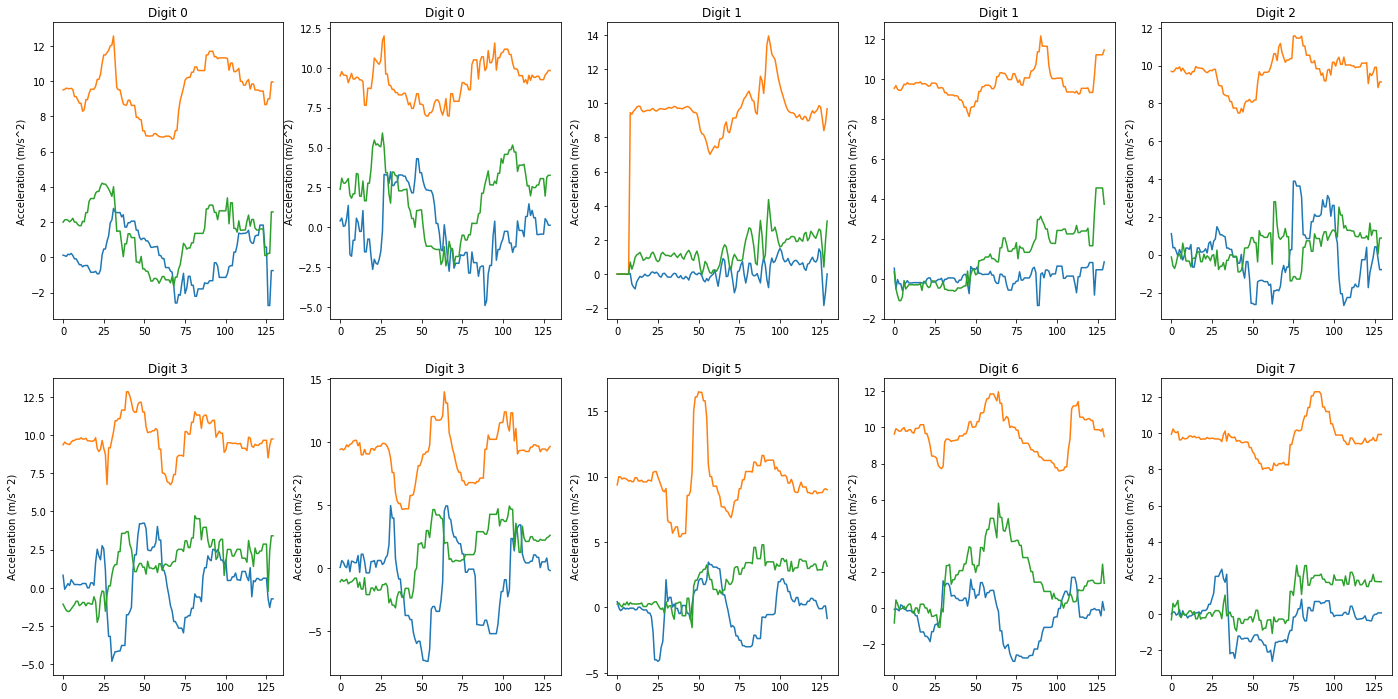

In [340]:
idx_plots = range(10, 110, 10)
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24, 12))
for m in range(2):
    for n in range(5):
        for i in range(3):
                axes[m, n].plot(np.arange(sample_size), x_sampled[idx_plots[m*5+n]][:, i])
                axes[m, n].set_title("Digit {}".format(label[idx_plots[m*5+n]]))
                #axes[m, n].set_xlabel('Time')
                axes[m, n].set_ylabel('Acceleration (m/s^2)')

plt.show()

### Model Training
* Build a neural network by inputing the number of neurons and layers as well as activation functions.
* Set up an optimizer to minimize the loss
* Fit the model with training set and observe the training and validation accuracy over iterations (epochs)
* Check the model summary to understand the model structure and size

#### Train a 3-layer fully connected neural network (DNN)

In [284]:
# Build the structure of the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_path = './mnist_dnn.hdf5'

In [285]:
# Set up an optimizer to minimize the loss
# Set up an metric to monitor during the training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [294]:
# Fit the model with the training set 
# Observe the accuracy and loss over epochs
model_save = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, 
                                                monitor='val_loss', mode='min')
model.fit(X_train, y_train, epochs=100, batch_size=30,
          validation_data=(X_val, y_val),
          callbacks=[model_save])

Train on 360 samples, validate on 97 samples
Epoch 1/100
360/360 [==============================] - 0s 176us/sample - loss: 0.1338 - accuracy: 0.9583 - val_loss: 1.1983 - val_accuracy: 0.7938
Epoch 2/100
360/360 [==============================] - 0s 109us/sample - loss: 0.1449 - accuracy: 0.9556 - val_loss: 1.2824 - val_accuracy: 0.8041
Epoch 3/100
360/360 [==============================] - 0s 156us/sample - loss: 0.1228 - accuracy: 0.9500 - val_loss: 1.0012 - val_accuracy: 0.7732
Epoch 4/100
360/360 [==============================] - 0s 112us/sample - loss: 0.1286 - accuracy: 0.9472 - val_loss: 1.1447 - val_accuracy: 0.8041
Epoch 5/100
360/360 [==============================] - 0s 113us/sample - loss: 0.1945 - accuracy: 0.9306 - val_loss: 1.3376 - val_accuracy: 0.7629
Epoch 6/100
360/360 [==============================] - 0s 109us/sample - loss: 0.2080 - accuracy: 0.9194 - val_loss: 1.2305 - val_accuracy: 0.8144
Epoch 7/100
360/360 [==============================] - 0s 108us/sample - 

In [295]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             multiple                  25024     
_________________________________________________________________
dropout_26 (Dropout)         multiple                  0         
_________________________________________________________________
dense_40 (Dense)             multiple                  8320      
_________________________________________________________________
dropout_27 (Dropout)         multiple                  0         
_________________________________________________________________
dense_41 (Dense)             multiple                  1290      
Total params: 34,634
Trainable params: 34,634
Non-trainable params: 0
_________________________________________________________________


#### Model evaluation

In [296]:
model.load_weights(model_path)

In [297]:
print("Validation loss and accuracy")
_ = model.evaluate(X_val,  y_val, verbose=2)

Validation loss and accuracy
97/1 - 0s - loss: 0.5006 - accuracy: 0.7732


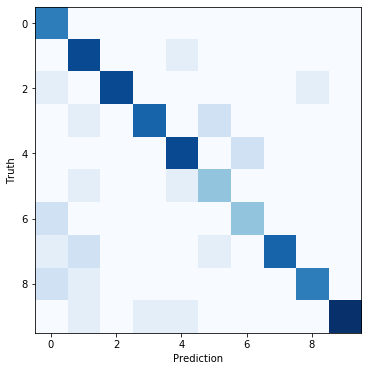

In [298]:
cm_val = confusion_matrix(np.dot(y_val, range(num_classes)), 
                      model.predict_classes(X_val))
plt.figure(figsize=(8, 6))
plt.imshow(cm_val, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show()

In [292]:
print("Test loss and accuracy")
_ = model.evaluate(test_X,  test_y, verbose=2)

Test loss and accuracy
50/1 - 0s - loss: 2.3878 - accuracy: 0.6400


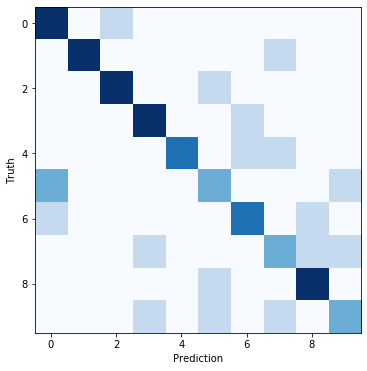

In [293]:
cm_test = confusion_matrix(np.dot(test_y, range(num_classes)), 
                      model.predict_classes(test_X))
plt.figure(figsize=(8, 6))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show()

### Model Manager Library

The model manager library help manage models and their deployements. 

In [195]:
mm.save_model(model, 'mnist_air')

=== save_model ===
INFO:tensorflow:Assets written to: ./models/model-mnist_air-1.0.0/1/assets


In [196]:
mm.list_models()

[{'model_name': 'mnist_air', 'model_version': '1.0.0'},
 {'model_name': 'mnist_air_cnn', 'model_version': '1.0.0'},
 {'model_name': 'handwritten_digits', 'model_version': '1.0.0'}]

In [197]:
mm.deploy_model('mnist_air')

{'model_name': 'mnist_air', 'model_version': '1.0.0', 'status': 'started'}

In [198]:
mm.list_deployments()

{'container_list': [{'model_name': 'mnist_air',
   'model_version': '1.0.0',
   'state': 'running'}],
 'status': 'success'}

In [199]:
test_idx = 12
in_data = X_val[test_idx].tolist()
model_name = 'mnist_air'
model_version = '1.0.0'
resp = mm.test_minst_air(in_data, model_name)
print("The probabilities of the 10 digits are {}".format(resp))
predicted_num = np.argmax(resp['predictions'])
print("The digit is predicted to be {}.".format(predicted_num))
groudtruth_label = np.dot(y_val[test_idx], np.arange(10))
print("The digit is {}.".format(groudtruth_label))

The probabilities of the 10 digits are {'predictions': [0.000129719207, 0.00225073961, 0.135449871, 0.827634573, 0.000948134577, 0.0175229665, 0.000126890693, 0.0109360917, 0.00479349727, 0.000207604651]}
The digit is predicted to be 3.
The digit is 3.0.


In [194]:
#mm.stop_deployment('mnist_air')

{'model_name': 'mnist_air', 'model_version': '1.0.0', 'status': 'stopped'}

In [200]:
mm.list_deployments()

{'container_list': [{'model_name': 'mnist_air',
   'model_version': '1.0.0',
   'state': 'running'}],
 'status': 'success'}

### More analysis

#### Sample size distribution

Sample size distribution: 
count    457.000000
mean     180.221007
std       38.423902
min       80.000000
25%      158.000000
50%      178.000000
75%      200.000000
max      354.000000
dtype: float64


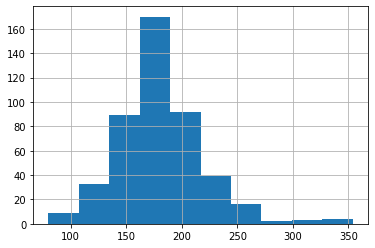

In [105]:
sample_size_list = [m.shape[0] for m in x_raw]
print("Sample size distribution: ")
print(pd.Series(sample_size_list).describe())

pd.Series(sample_size_list).hist()
plt.show()

#### Input size vs. Accuracy

In [48]:
input_size_list = range(10, 200, 10)
random_seeds = [1, 3, 11, 23, 56, 97]
num_classes = 10

In [50]:
acc_svm_random_end_val = []
acc_svm_random_end_test = []

for input_size in input_size_list:
    for random_seed in random_seeds:
        x_sampled = preprocess(input_size, x_raw, random_seed=random_seed)
        #print("Input size: {}, random seed: {}, sampled data {}". format(input_size, random_seed, sampled_data.shape))
        X_train, X_val, y_train, y_val = split_data(x_sampled, label, train_idx=360,
                                                    random_seed=random_seed)
        tmp = np.asarray(preprocess(input_size, test_x_raw))
        test_X = np.asarray(tmp, dtype=np.float32).reshape(tmp.shape[0], -1)
        test_y = np.eye(num_classes)[np.array(test_label)]
        
        svc = SVC(C=1.0, kernel='poly', degree=3, decision_function_shape='ovo', gamma='auto')
        svc.fit(X_train, np.dot(y_train, range(num_classes)))
        acc_svm_random_end_val.append(svc.score(X_val, np.dot(y_val, range(num_classes))))
        acc_svm_random_end_test.append(svc.score(test_X, np.dot(test_y, range(num_classes))))

In [51]:
acc_svm_random_begin_val = []
acc_svm_random_begin_test = []

for input_size in input_size_list:
    for random_seed in random_seeds:
        x_sampled = preprocess(input_size, x_raw, padding='begin',
                               random_seed=random_seed)
        #print("Input size: {}, random seed: {}, sampled data {}". format(input_size, random_seed, sampled_data.shape))
        X_train, X_val, y_train, y_val = split_data(x_sampled, label, train_idx=360,
                                                    random_seed=random_seed)
        tmp = np.asarray(preprocess(input_size, test_x_raw))
        test_X = np.asarray(tmp, dtype=np.float32).reshape(tmp.shape[0], -1)
        test_y = np.eye(num_classes)[np.array(test_label)]
        
        svc = SVC(C=1.0, kernel='poly', degree=3, decision_function_shape='ovo', gamma='auto')
        svc.fit(X_train, np.dot(y_train, range(num_classes)))
        acc_svm_random_begin_val.append(svc.score(X_val, np.dot(y_val, range(num_classes))))
        acc_svm_random_begin_test.append(svc.score(test_X, np.dot(test_y, range(num_classes))))

In [52]:
acc_mean_end_val, acc_std_end_val = mean_std_acc(acc_svm_random_end_val)
acc_mean_begin_val, acc_std_begin_val = mean_std_acc(acc_svm_random_begin_val)

acc_mean_end_test, acc_std_end_test = mean_std_acc(acc_svm_random_end_test)
acc_mean_begin_test, acc_std_begin_test = mean_std_acc(acc_svm_random_begin_test)

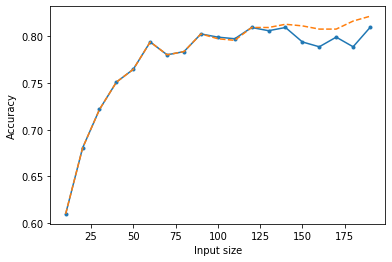

In [53]:
plt.plot(input_size_list, acc_mean_end_val, '.-') # padding at the end
plt.plot(input_size_list, acc_mean_begin_val, '--') # padding at the beginning
plt.xlabel("Input size")
plt.ylabel("Accuracy")
plt.show()

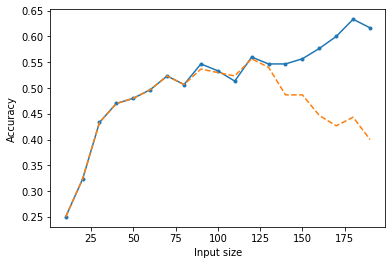

In [54]:
plt.plot(input_size_list, acc_mean_end_test, '.-') # padding at the end
plt.plot(input_size_list, acc_mean_begin_test, '--') # padding at the beginning
plt.xlabel("Input size")
plt.ylabel("Accuracy")
plt.show()

#### Train a simple Logistic Regression model as a baseline

In [ ]:
lg = LogisticRegression(penalty='l2', C=1.0, solver='newton-cg', multi_class='multinomial')
lg.fit(X_train, np.dot(y_train, range(num_classes)))

In [ ]:
print("Validation accuracy: {}".format(lg.score(X_val, np.dot(y_val, range(num_classes)))))
print("Test accuracy {}".format(lg.score(test_X, np.dot(test_y, range(num_classes)))))

#### Train a CNN

In [200]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(130, 3, 1), padding='SAME'),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu', padding='SAME'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [201]:
model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [202]:
model_path = './mnist_cnn.hdf5'
model_save = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, 
                                                monitor='val_loss', mode='min')
model_cnn.fit(X_train.reshape(-1, 130, 3, 1), y_train, 
              epochs=100, batch_size=20,
              validation_data=(X_val.reshape(-1, 130, 3, 1), y_val),
              callbacks=[model_save])

Train on 360 samples, validate on 97 samples
Epoch 1/100
360/360 [==============================] - 1s 3ms/sample - loss: 2.6093 - accuracy: 0.0861 - val_loss: 2.2617 - val_accuracy: 0.1649
Epoch 2/100
360/360 [==============================] - 0s 1ms/sample - loss: 2.1637 - accuracy: 0.2222 - val_loss: 2.0260 - val_accuracy: 0.3196
Epoch 3/100
360/360 [==============================] - 0s 1ms/sample - loss: 1.9528 - accuracy: 0.3083 - val_loss: 1.7300 - val_accuracy: 0.4227
Epoch 4/100
360/360 [==============================] - 0s 1ms/sample - loss: 1.6615 - accuracy: 0.4278 - val_loss: 1.5510 - val_accuracy: 0.4845
Epoch 5/100
360/360 [==============================] - 0s 1ms/sample - loss: 1.4637 - accuracy: 0.4778 - val_loss: 1.2435 - val_accuracy: 0.6082
Epoch 6/100
360/360 [==============================] - 0s 1ms/sample - loss: 1.2012 - accuracy: 0.5667 - val_loss: 0.9975 - val_accuracy: 0.6701
Epoch 7/100
360/360 [==============================] - 0s 1ms/sample - loss: 1.0819 -

In [196]:
model_cnn.load_weights(model_path)

In [197]:
print("Validation loss and accuracy")
_ = model_cnn.evaluate(X_val.reshape(-1, 130, 3, 1),  y_val, verbose=2)

Validation loss and accuracy
97/1 - 0s - loss: 3.4751 - accuracy: 0.8247


In [198]:
print("Test loss and accuracy")
_ = model_cnn.evaluate(test_X.reshape(-1, 130, 3, 1),  test_y, verbose=2)

Test loss and accuracy
50/1 - 0s - loss: 1.7758 - accuracy: 0.5600
